In [1]:
%pip install pythtb

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"PdGa_Ham2",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

In [20]:
# To write the band velocity operator at a k-point
def calculate_v_euler_forward(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [21]:
# method 1 .........

# To get energy eigenvalues and corresponding OAMs at a k-point
def solve_and_calculate_L(k_vec, eta=0.01):
    v = calculate_v_euler_forward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    
    # Getting energy eigenvalues and vectors
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating 3 components of OAM
    Lx = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lx[n] = np.imag(temp)
    Ly = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Ly[n] = np.imag(temp)
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    return (eig_values, np.array((Lx, Ly, Lz)))

In [22]:
# defining hamiltonian
import numpy as np
import math
# angular momentum for Ga ( p-obital)
Lz_Ga = [[0,0,0],[0,0,-1j],[0,1j,0]]
Lx_Ga = [[0,0,0],[0,0,-1j],[0,1j,0]]
Ly_Ga = [[0,0,1j],[0,0,0],[-1j,0,0]]

# angular momentum for Pd ( d-obital)
Lz_Pd = [[0,0,0,0,0],[0,0,-1j,0,0],[0,1j,0,0,0],[0,0,0,0,-2j],[0,0,0,2j,0]]
Ly_Pd = [[0,-1j,0,0,0],[1j,0,0,0,-1j],[0,0,0,-1j*math.sqrt(3),0],[0,0,1j*math.sqrt(3),0,0],[0,1j,0,0,0]]
Lx_Pd = [[0,0,1j,0,0],[0,0,0,0,-1j],[-1j,0,0,-1j*math.sqrt(3),0],[0,0,1j*math.sqrt(3),0,0],[0,1j,0,0,0]]

In [ ]:
# method 2 .............

def L_matrix(L_Ga, L_Pd, choice_of_xyz):

    if choice_of_xyz == 'x':

        Lx_Pd = np.tile(L_Pd[0], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lx_Ga = np.tile(L_Ga[0], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lx = np.zeros((32, 32), dtype=complex)
        Lx[0:20, 0:20] = Lx_Pd
        Lx[20:32, 20:32] = Lx_Ga
        Lx = np.kron(np.eye(2), Lx)

        return np.imag(Lx)
    
    elif choice_of_xyz == 'y':
        Ly_Pd = np.tile(L_Pd[1], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Ly_Ga = np.tile(L_Ga[1], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Ly = np.zeros((32, 32), dtype=complex)
        Ly[0:20, 0:20] = Ly_Pd
        Ly[20:32, 20:32] = Ly_Ga
        Ly = np.kron(np.eye(2), Ly)

        return np.imag(Ly)
    elif choice_of_xyz == 'z':
        Lz_Pd = np.tile(L_Pd[2], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lz_Ga = np.tile(L_Ga[2], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lz = np.zeros((32, 32), dtype=complex)
        Lz[0:20, 0:20] = Lz_Pd
        Lz[20:32, 20:32] = Lz_Ga
        Lz = np.kron(np.eye(2), Lz)

        return np.imag(Lz) 
    else :     # for all 
        Lx_Pd = np.tile(L_Pd[0], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lx_Ga = np.tile(L_Ga[0], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lx = np.zeros((32, 32), dtype=complex)
        Lx[0:20, 0:20] = Lx_Pd
        Lx[20:32, 20:32] = Lx_Ga
        Lx = np.kron(np.eye(2), Lx)

        Ly_Pd = np.tile(L_Pd[1], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Ly_Ga = np.tile(L_Ga[1], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Ly = np.zeros((32, 32), dtype=complex)
        Ly[0:20, 0:20] = Ly_Pd
        Ly[20:32, 20:32] = Ly_Ga
        Ly = np.kron(np.eye(2), Ly)

        Lz_Pd = np.tile(L_Pd[2], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lz_Ga = np.tile(L_Ga[2], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lz = np.zeros((32, 32), dtype=complex)
        Lz[0:20, 0:20] = Lz_Pd
        Lz[20:32, 20:32] = Lz_Ga
        Lz = np.kron(np.eye(2), Lz)

        # ? // is it necessary 
        Lx = np.imag(Lx)
        Ly = np.imag(Ly)
        Lz = np.imag(Lz)
        return [Lx,Ly,Lz]

In [43]:
L_Ga = [Lx_Ga, Ly_Ga, Lz_Ga ]
L_Pd = [Lx_Pd, Ly_Pd, Lz_Pd ]
choice_of_xyz = ''
result = L_matrix(L_Ga, L_Pd, '')

In [31]:
# for method 1 ..........

# Choosing the path
path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,64,report=False)


evals=my_model.solve_all(k_vec)
energies = evals - 6.87 # Subtructing the Fermi energy

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0]+L[1]+L[2]     # L_111

1 points done.
51 points done.


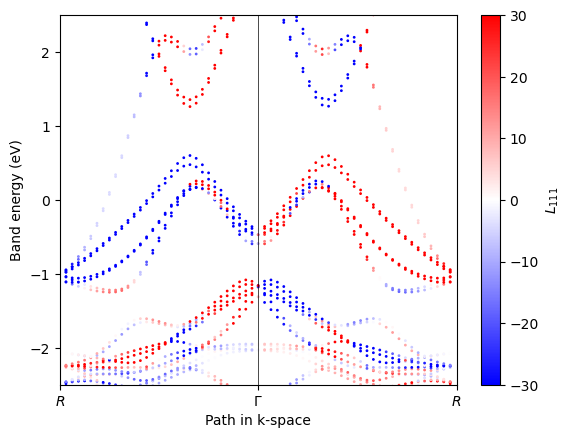

In [32]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{111}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

In [ ]:
# for method 2 .............

path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,64,report=False)


# Getting energy eigenvalues and vectors
(eig_values, eig_vectors) = my_model.solve_all(k_vec, eig_vectors=True)

energies = eig_values - 6.87 # Subtructing the Fermi energy
#print(energies.shape)
# Calculating OAM

# ? // how to handle this
L = L_matrix(L_Ga, L_Pd,'z')
Lx = np.dot(eig_vectors, L[0])
Lx = np.imag(Lx)
Ly = np.dot(eig_vectors, L[1])
Ly = np.imag(Ly)
Lz = np.dot(eig_vectors, L[2])
Lz = np.imag(Lz)
#print(L[0].shape)
colors = Lx + Ly + Lz    # 
print(colors.shape)

(64, 64)


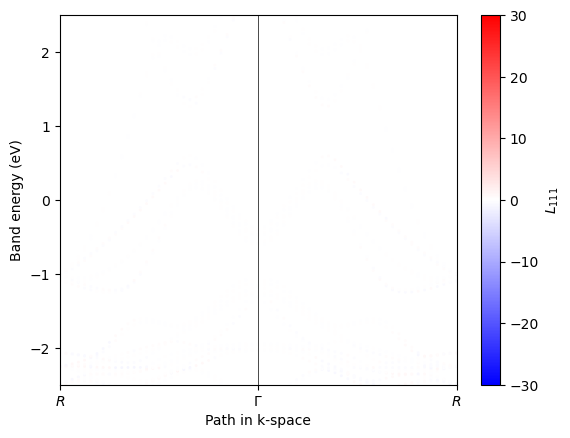

In [53]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{111}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

In [ ]:
# method 1 ................

# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz_method1(k_vec, eta=0.0001):
    v = calculate_v_euler_forward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [ ]:
# method 2 ................

# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz_method2(k_vec, eta=0.0001):
    v = calculate_v_euler_forward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    Lz = L_matrix(L_Ga, L_Pd, 'z')

    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [ ]:
# method 1 ..........

# Choosing the path
path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz_method1(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

In [ ]:
# method 2 ..........

# Choosing the path
path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz_method2(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

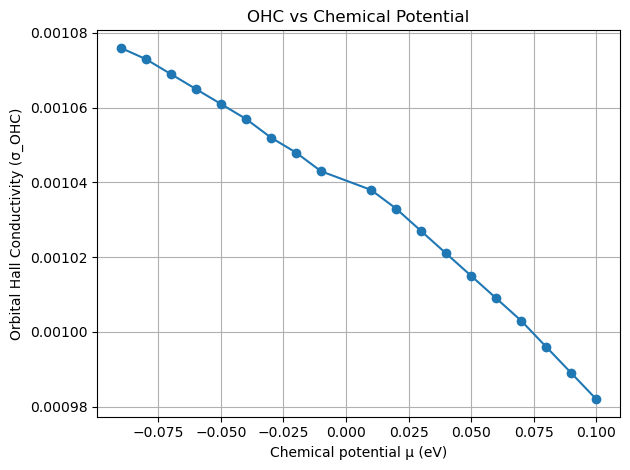

In [1]:
import matplotlib.pyplot as plt

mu = [-0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
       0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.10]

ohc = [0.001076, 0.001073, 0.001069, 0.001065, 0.001061, 0.001057, 0.001052,
       0.001048, 0.001043, 0.001038, 0.001033, 0.001027, 0.001021, 0.001015,
       0.001009, 0.001003, 0.000996, 0.000989, 0.000982]

plt.plot(mu, ohc, marker='o', linestyle='-')
plt.xlabel("Chemical potential μ (eV)")
plt.ylabel("Orbital Hall Conductivity (σ_OHC)")
plt.title("OHC vs Chemical Potential")
plt.grid(True)
plt.tight_layout()
plt.show()
